In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from graspologic.align import OrthogonalProcrustes
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.simulations import sample_edges
from pkg.inference import difference, difference_norm
from pkg.plot import heatmap

In [18]:
def compute_diff_mats(X, Y, d=2):
    X_hat = AdjacencySpectralEmbed(n_components=d, check_lcc=False).fit_transform(X)
    Y_hat = AdjacencySpectralEmbed(n_components=d, check_lcc=False).fit_transform(Y)

    exact = difference(X_hat, Y_hat, "exact")
    exact_norm = np.linalg.norm(exact)
    # exact = exact @ exact.T

    global_ = difference(X_hat, Y_hat, "global")
    global_norm = np.linalg.norm(global_)
    # global_ = global_ @ global_.T

    vertex = difference(X_hat, Y_hat, "vertex")
    vertex_norm = np.linalg.norm(vertex)
    # vertex = vertex @ vertex.T

    # idx = np.diag_indices_from(exact)
    # exact[idx] = 0
    # global_[idx] = 0
    # vertex[idx] = 0

    return exact, global_, vertex, exact_norm, global_norm, vertex_norm

In [40]:
def simulate(scale, reps=100):
    n = 25
    ns = [n, n]
    node_labels = ["Left"] * n + ["Right"] * n
    u = np.array(
        [
            [1 / 4, 3 / 4],
            [3 / 4, 1 / 4],
        ]
    )
    X = np.tile(u, n).reshape(-1, 2)

    w = np.array(
        [
            [4 / 5, 2 / 5],
            [2 / 5, 2.1 / 5],
        ]
    )
    Y = np.tile(w, n).reshape(-1, 2)

    networks = []
    diffs = []
    norms = []

    for i in range(reps):
        np.random.seed(i * 4 + 100)

        if scale == "exact":
            P1 = X @ X.T
            P2 = X @ X.T
        elif scale == "global":
            P1 = X @ X.T * 1.1
            P2 = X @ X.T * 0.9
        elif scale == "vertex":
            degree_correction = np.diag(np.tile(np.linspace(0.75, 1, n), 2))
            # degree_correction = np.diag(np.random.uniform(size=50))
            P1 = X @ X.T
            P2 = degree_correction @ X @ X.T @ degree_correction
        elif scale == "different":
            # degree_correction = np.diag(np.random.uniform(0.8, 1, n * 2))
            P1 = Y @ Y.T
            degree_correction = np.diag(np.tile(np.linspace(0.75, 1.1, n), 2))
            # degree_correction = np.diag(np.random.uniform(0.2, 1, size=n * 2))
            P2 = degree_correction @ X @ X.T @ degree_correction
            # P2 = X @ X.T
        else:
            raise ValueError()

        A = sample_edges(P1)
        B = sample_edges(P2)

        C, D, E, U, V, W = compute_diff_mats(A, B)

        networks.append([A, B])
        diffs.append([C, D, E])
        norms.append([U, V, W])

    return (
        np.array(networks).mean(axis=0),
        np.array(diffs).mean(axis=0),
        np.array(norms).mean(axis=0),
    )

In [ ]:
out = [simulate(i) for i in ["exact", "global", "vertex", "different"]]

res = np.array([out[i][0] for i in range(4)])
diffs = np.array([out[i][1] for i in range(4)])
norms = np.array([out[i][2] for i in range(4)])

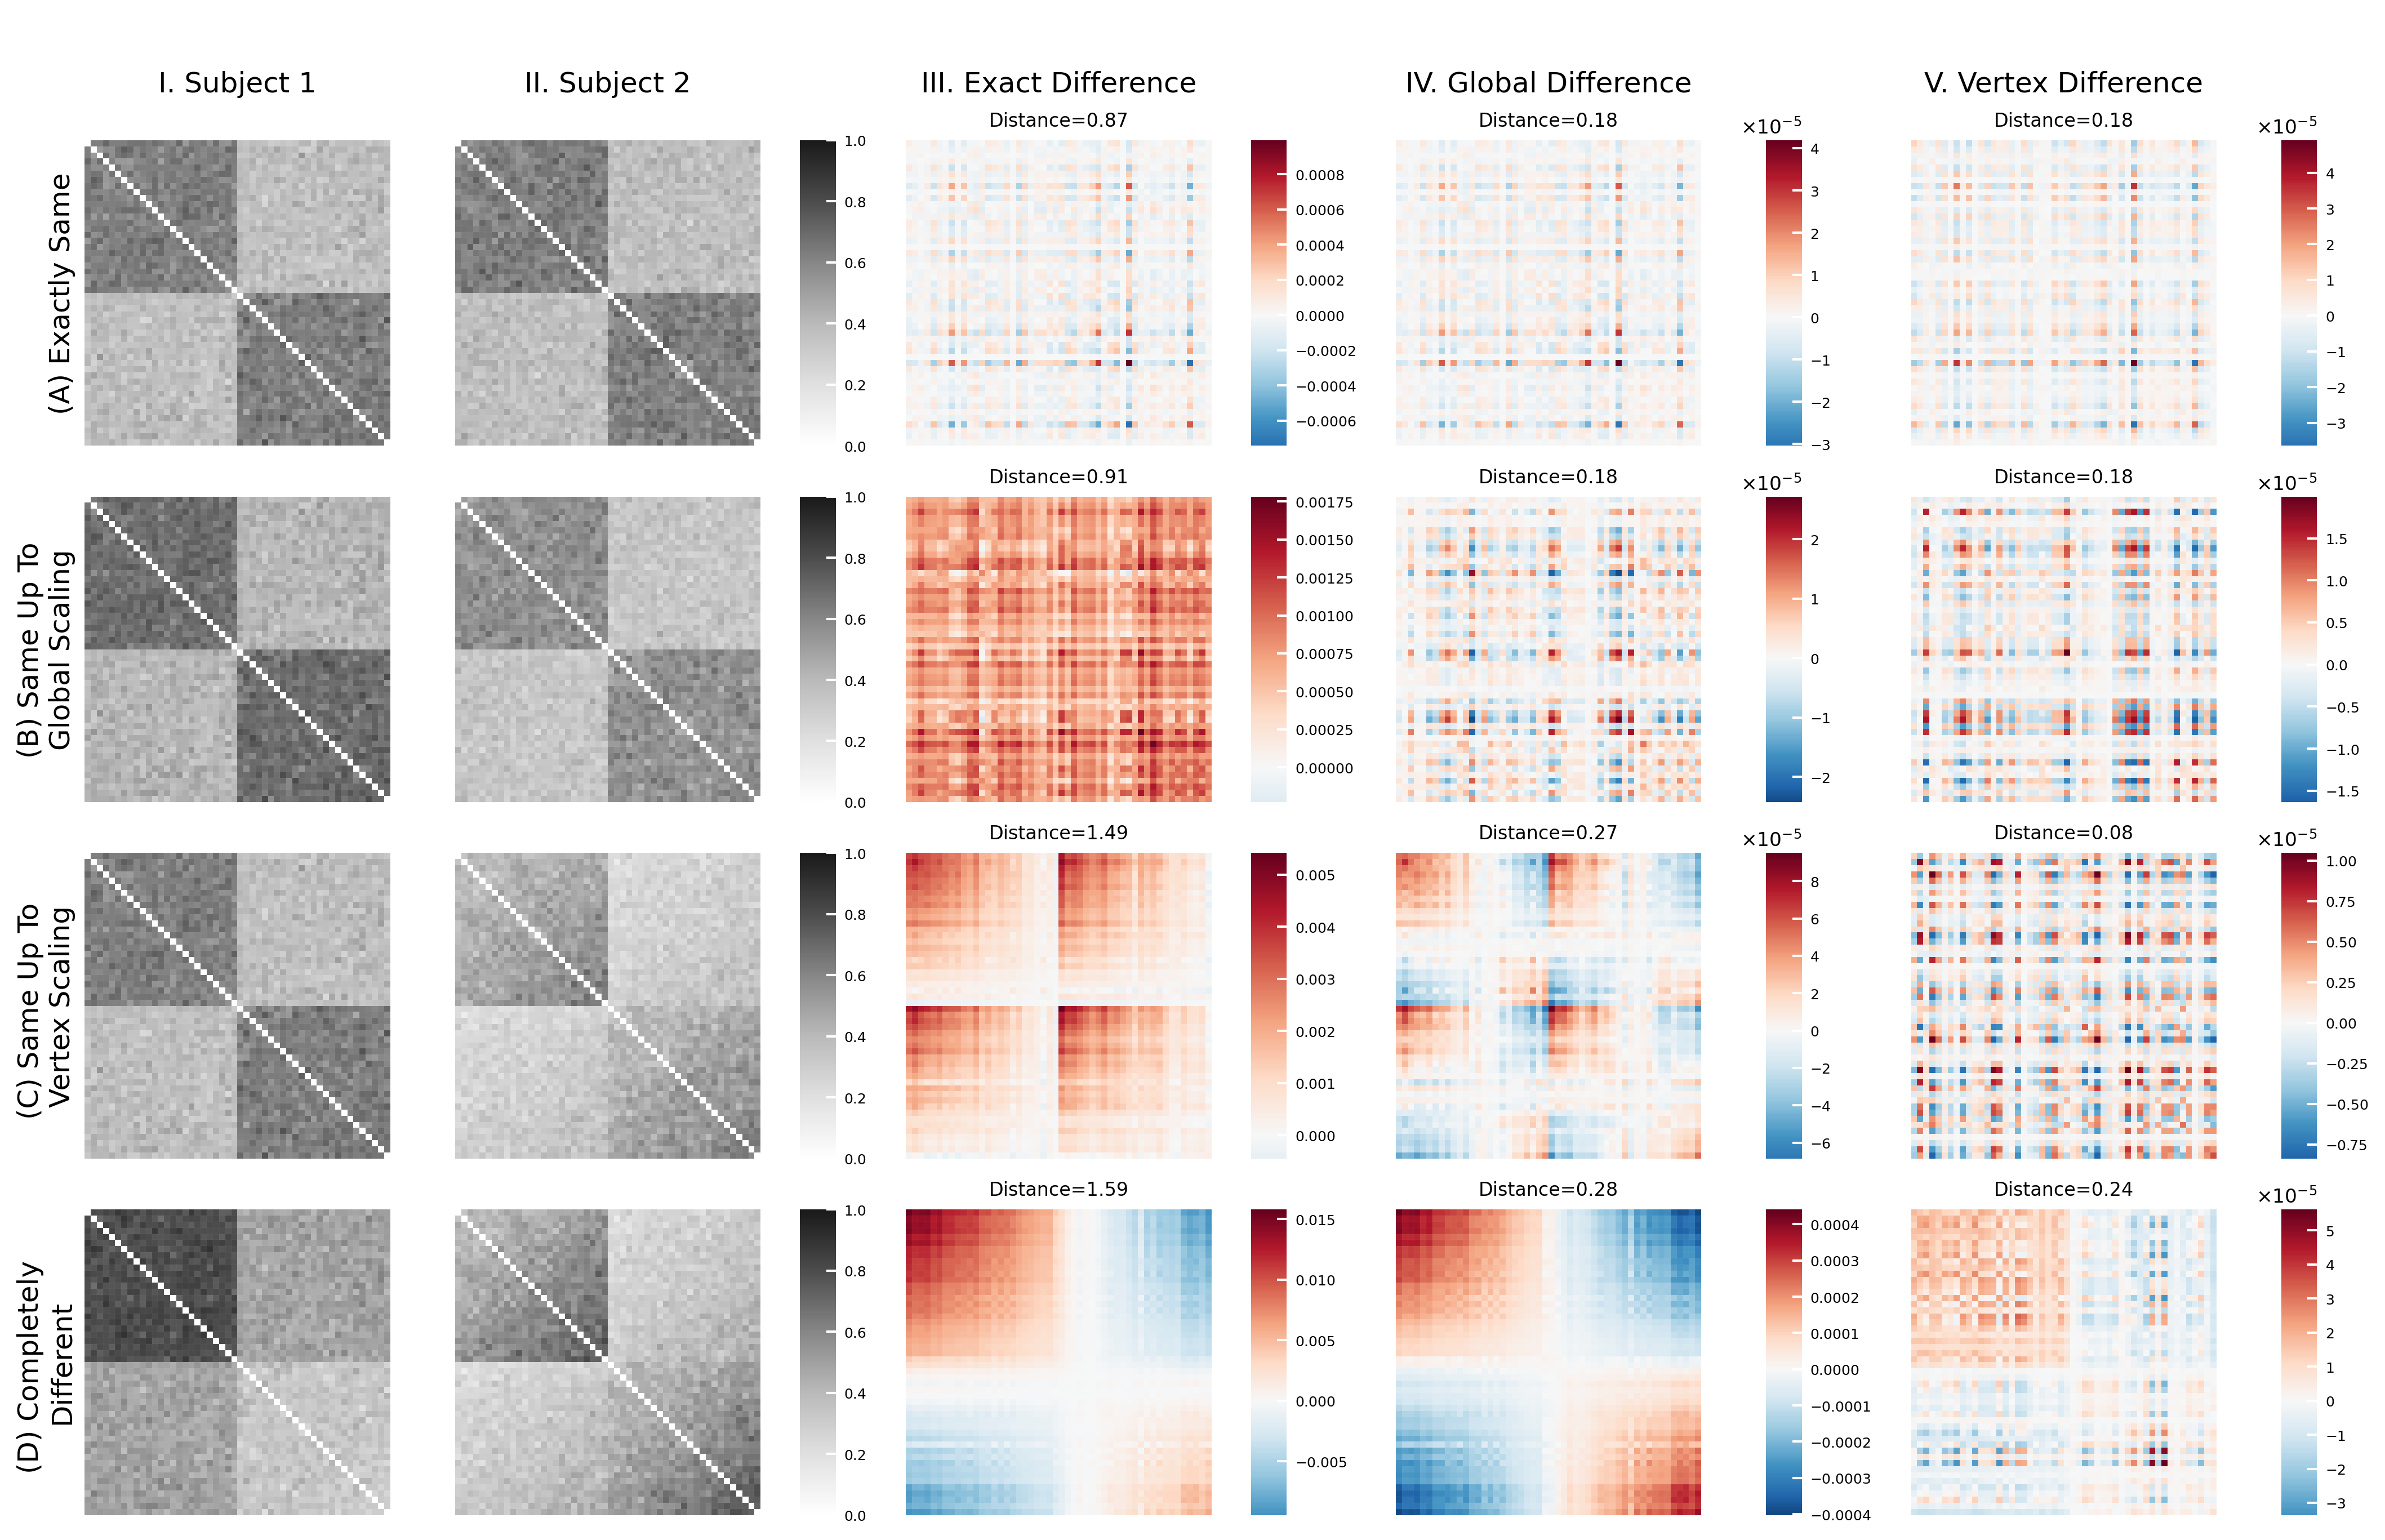

In [50]:
sns.set_context("talk", font_scale=0.5)

fig, ax = plt.subplots(
    nrows=5,
    ncols=9,
    figsize=(14, 9),
    dpi=300,
    height_ratios=[0.05, 1, 1, 1, 1],
    width_ratios=[1, 1, 0.1, 1, 0.1, 1, 0.1, 1, 0.1],
    constrained_layout=True,
)

# plot average networks
to_plot = res[:, :2]
to_ax = ax[1:, :3]

for rdx, row in enumerate(to_plot):
    vmin = np.min(row)
    vmax = np.max(row)
    for cdx, col in enumerate(row):
        if cdx == 0:
            heatmap_kwargs = dict(
                vmin=0,
                vmax=1,
                cbar=False,
                # cbar_ax=to_ax[rdx, -1],
                cmap="RdGy",
            )
        else:
            heatmap_kwargs = dict(
                vmin=0,
                vmax=1,
                cbar=True,
                cbar_ax=to_ax[rdx, -1],
                cmap="RdGy",
            )

        heatmap(
            col,
            ax=to_ax[rdx, cdx],
            # axes_labels=node_labels,
            heatmap_kwargs=heatmap_kwargs,
        )

    cbar = to_ax[rdx, -1]
    # cbar.set_ylabel(
    #     "Edge Weight",
    # )
    # cbar.set_yticks([0, 0.5, 1], ["0", "0.5", "1"])
    cbar.tick_params(direction="in", length=4, width=1, color="w", labelsize=6)

# plot diffs
to_plot = diffs
to_ax = ax[1:, 3:]

heatmap_idx = [0, 2, 4]
cbar_idx = [1, 3, 5]

for rdx, row in enumerate(to_plot):
    vmin1 = np.min(row[0])
    vmax1 = np.max(row[0])

    vmin2 = np.min(row[1])
    vmax2 = np.max(row[1])

    for cdx, col in enumerate(row):
        if cdx == 0:
            vmin = vmin1
            vmax = vmax1
        else:
            vmin = vmin2
            vmax = vmax2
        heatmap(
            col @ col.T,
            ax=to_ax[rdx, heatmap_idx[cdx]],
            # axes_labels=node_labels,
            heatmap_kwargs=dict(
                # vmin=vmin,
                # vmax=vmax,
                cbar=True,
                cbar_ax=to_ax[rdx, cbar_idx[cdx]],
                cmap="RdBu_r",
            ),
        )
        cbar = to_ax[rdx, cbar_idx[cdx]]
        cbar.tick_params(
            axis="y",
            direction="in",
            length=4,
            width=1,
            color="w",
            labelsize=6,
        )
        cbar.ticklabel_format(axis="y", scilimits=[-2, 2])
        # cbar.ticklabel_format(useMathText=True)
        cbar.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True))
        val = np.linalg.norm(col)
        to_ax[rdx, heatmap_idx[cdx]].set_title(
            f"Distance={norms[rdx, cdx]:.2f}", fontdict=dict(fontsize=8)
        )

for a in ax[0]:
    sns.despine(ax=a, left=True, bottom=True)
    a.tick_params(axis="both", which="both", bottom=False, left=False, top=False)
    a.set_yticklabels("")
    a.set_xticklabels("")

to_ax = ax[0]
y_titles = [
    "I. Subject 1",
    "II. Subject 2",
    "III. Exact Difference",
    "IV. Global Difference",
    "V. Vertex Difference",
]

for idx, col in enumerate([0, 1, 3, 5, 7]):
    to_ax[col].set_xlabel(
        y_titles[idx],
        fontdict=dict(fontsize=12),
    )

to_ax = ax[1:, 0]
x_titles = [
    "(A) Exactly Same",
    "(B) Same Up To\nGlobal Scaling",
    "(C) Same Up To \nVertex Scaling",
    "(D) Completely \nDifferent",
]

for idx, row in enumerate(range(4)):
    to_ax[row].set_ylabel(
        x_titles[row],
        fontdict=dict(fontsize=12),
    )

In [51]:
fig.savefig("./figures/3-simulations.pdf", bbox_inches="tight")